In [1]:
import cv2 as cv
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import seaborn as sns
from scipy import stats
import os
import re
import pickle
import imutils
from scipy.signal import find_peaks, savgol_filter
from pathlib import Path
import glob
from pathlib import Path
import pandas as pd
from tqdm import tqdm
from utils import noise_detection,  cfar_fast
from utils import find_periods

In [2]:
def init_condition(avis, x, y):
    capture = cv.VideoCapture(avis)
    _, frame1 = capture.read()
    
    # Crop to the selected 50x50 region
    frame1 = frame1[y:y+50, x:x+80]
    
    num_frames = int(capture.get(cv.CAP_PROP_FRAME_COUNT))
    hsv = np.zeros_like(frame1)
    hsv[..., 1] = 255  # Set saturation channel
    
    return capture, num_frames, hsv

In [3]:
def select_roi_interactive(avis):
    roi_x = 80
    roi_y = 50
    # Initialize video capture
    capture = cv.VideoCapture(avis)
    ret, frame = capture.read()
    if not ret:
        raise ValueError("Failed to read video")
    
    # Variables to store ROI coordinates
    roi_selected = False
    x_center, y_center = -1, -1

    # Mouse callback function
    def mouse_callback(event, x, y, flags, param):
        nonlocal roi_selected, x_center, y_center
        if event == cv.EVENT_LBUTTONDOWN:
            x_center, y_center = x, y
            roi_selected = True

    # Create window and set mouse callback
    cv.namedWindow("Select ROI Center")
    cv.setMouseCallback("Select ROI Center", mouse_callback)

    while True:
        display_frame = frame.copy()
        if roi_selected:
            # Ensure ROI stays within frame boundaries
            x = max(0, min(x_center - int(roi_x/2), frame.shape[1] - roi_x))
            y = max(0, min(y_center - int(roi_y/2), frame.shape[0] - roi_y))
            
            # Draw the 50x50 ROI rectangle
            cv.rectangle(display_frame, (x, y), (x+roi_x, y+roi_y), (0, 255, 0), 2)
            
            # Show cropped preview in a new window
            cropped_preview = frame[y:y+roi_y, x:x+roi_x]
            cv.imshow("Cropped Preview", cropped_preview)
        
        cv.imshow("Select ROI Center", display_frame)
        key = cv.waitKey(1) & 0xFF
        if key == ord('q') and roi_selected:  # Press 'q' to confirm
            break
        elif key == 27:  # Press ESC to exit
            cv.destroyAllWindows()
            capture.release()
            return None, None

    cv.destroyAllWindows()
    capture.release()
    
    # Final ROI coordinates (top-left corner)
    x = max(0, min(x_center - int(roi_x/2), frame.shape[1] - roi_x))
    y = max(0, min(y_center - int(roi_y/2), frame.shape[0] - roi_y))
    return x, y

# Input data

In [4]:
fish_date = "2024-08-01"
no = "F4"
set_no = no + "_01"

main_dir = f"F:\\Temp_opto\\{fish_date}\\lcr\\SIDECAMERA\\{no}\\{set_no}"
top_dir = f"F:\\Temp_opto\\{fish_date}\\lcr\\TOPCAMERA\\{no}\\{set_no}"

avis = glob.glob(f"{main_dir}/**.avi")
avis = [str(Path(avi).resolve()) for avi in avis]
mp4s = glob.glob(f"{top_dir}/**.mp4")
mp4s = [str(Path(mp4).resolve()) for mp4 in mp4s]
avis

['F:\\Temp_opto\\2024-08-01\\lcr\\SIDECAMERA\\F4\\F4_01\\FLIR_2024-08-01_F4_01-T1-0000.avi',
 'F:\\Temp_opto\\2024-08-01\\lcr\\SIDECAMERA\\F4\\F4_01\\FLIR_2024-08-01_F4_01-T2-0000.avi',
 'F:\\Temp_opto\\2024-08-01\\lcr\\SIDECAMERA\\F4\\F4_01\\FLIR_2024-08-01_F4_01-T3-0000.avi',
 'F:\\Temp_opto\\2024-08-01\\lcr\\SIDECAMERA\\F4\\F4_01\\FLIR_2024-08-01_F4_01-T4-0000.avi']

In [5]:
avi = avis[0]
mp4 = mp4s[0]
fish_id = fish_date + '-' + no
h5_path = mp4.split('.')[0] + ".h5"

save_dir = f"F:/swim_motion_data/sidecam/lcr_v2/{fish_id}/{set_no}/Trial{1}"
Path(save_dir).mkdir(parents=True, exist_ok = True)

In [6]:
if Path(f"{save_dir}/cord.txt").exists():
   with open(f"{save_dir}/cord.txt", "r") as f:
       x_cord = int(f.readline().split()[-1])
       y_cord = int(f.readline().split()[-1])
else:
    import winsound
    frequency = 2500  # Set Frequency To 2500 Hertz
    duration = 500  # Set Duration To 1000 ms == 1 second
    winsound.Beep(frequency, duration)
    x_cord, y_cord = select_roi_interactive(avi)
    with open(f"{save_dir}/cord.txt", "w") as f:
        f.write("x\t" + str(x_cord))
        f.write("\ny\t" + str(y_cord))
capture, num_frames, hsv = init_condition(avi, x_cord, y_cord)

## preview the cropped video

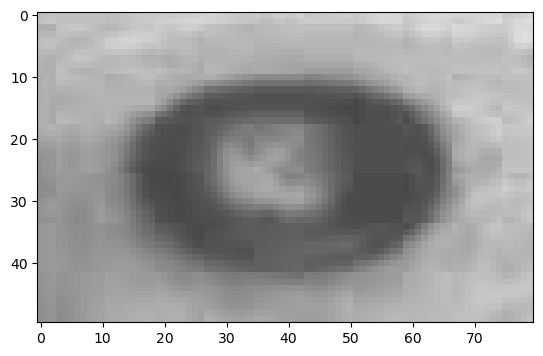

In [7]:
capture.set(cv.CAP_PROP_POS_FRAMES, 0)

# Read and crop the first frame again
ret, frame = capture.read()
if ret:
    cropped_frame = frame[y_cord:y_cord+50, x_cord:x_cord+80]
    plt.imshow(cropped_frame)

# Step 1: calcuate mean squared erro(mseval) and fit bimodel

In [8]:
# sns.kdeplot(mseval, shade=True,color='crimson', label='KDE')

In [9]:
# from tqdm import tqdm
# from sklearn.mixture import GaussianMixture

# mseval = np.zeros(num_frames - 1) 
# ret, prev_frame = capture.read()
# prev_frame = prev_frame[y_cord:y_cord+50, x_cord:x_cord+50]
# prev_gray = cv.cvtColor(prev_frame, cv.COLOR_BGR2GRAY).astype(np.float32)

# for i in tqdm(range(1, num_frames)):
#     ret, curr_frame = capture.read()
#     if not ret:
#         break
        
#     curr_frame = curr_frame[y_cord:y_cord+50, x_cord:x_cord+50]
#     curr_gray = cv.cvtColor(curr_frame, cv.COLOR_BGR2GRAY).astype(np.float32)

#     diff = curr_gray - prev_gray
#     mse = np.mean(diff ** 2)
#     mseval[i-1] = mse 
    
#     prev_gray = curr_gray.copy()

# ################ fitting
# gmm = GaussianMixture(n_components = 2)
# mseval = np.array(mseval)
# gmm.fit(mseval.reshape(-1, 1))

# x = np.linspace(0, np.ceil(np.max(mseval)), 10000).reshape(-1, 1)
# y = np.exp(gmm.score_samples(x))

# #### peak
# peaks, _ = find_peaks(y)  # Adjust `prominence` as needed
# peak1, peak2 = x[peaks[0]], x[peaks[1]]  # Two largest peaks

# # Get the values between the two peaks and find the minimum
# valid_indices = [i for i in range(x.shape[0]) if i > peaks[0] and i < peaks[1]]
# minimum = x[valid_indices[np.argmin(y[valid_indices])]]

# plt.axvline(minimum, color='black', linestyle='--', 
#             label='Inflection')
# plt.plot(x, y)

In [10]:
# mse_threshold = minimum
# res = [] ######## list for significant motion
# for a in range(len(mseval)):
#         if mseval[a] > mse_threshold:
#             res.append(a)
# frames = load_significant_frames(avi, res, x_cord, y_cord)

# Step 2: Optical Flow

In [11]:
res = list(range(0, num_frames))
len(res)

98000

In [12]:
if Path(f"{save_dir}/x_shift.npy").exists():
    horizontal_motion = np.load(f"{save_dir}/x_shift.npy")
else:
    horizontal_motion = []

    capture.set(cv.CAP_PROP_POS_FRAMES, 0)
    ret, prev_frame = capture.read()
    prev_frame = prev_frame[y_cord:y_cord+50, x_cord:x_cord+80]
    prev_gray = cv.cvtColor(prev_frame, cv.COLOR_BGR2GRAY)
    
    for frame in tqdm(range(1, num_frames), desc="Analyzing Motion"):
        ret, curr_frame = capture.read()
        if not ret:
            break
            
        curr_frame = curr_frame[y_cord:y_cord+50, x_cord:x_cord+80]
        curr_gray = cv.cvtColor(curr_frame, cv.COLOR_BGR2GRAY)
        
        # Calculate dense optical flow
        flow = cv.calcOpticalFlowFarneback(
            prev_gray, curr_gray, 
            None, 0.5, 3, 15, 3, 5, 1.2, 0
        )
        
        # Focus on horizontal motion (x-axis component)
        horizontal_flow = flow[..., 0]
        avg_horizontal = np.mean(horizontal_flow)
        horizontal_motion.append(avg_horizontal)
        
        prev_gray = curr_gray
    horizontal_motion = -np.array(horizontal_motion) ###### make positive to upward motion 
    np.save(f"{save_dir}/x_shift.npy", horizontal_motion)

In [13]:
horizontal_motion.shape

(97999,)

# Step 3: Find episode

In [14]:
noise_level = noise_detection(
    horizontal_motion,
    noise_window=20,       # Larger for stable baselines
    min_duration=1,        # Minimum frames for valid peak
    prominence_factor=5  # Higher = fewer false positives
)

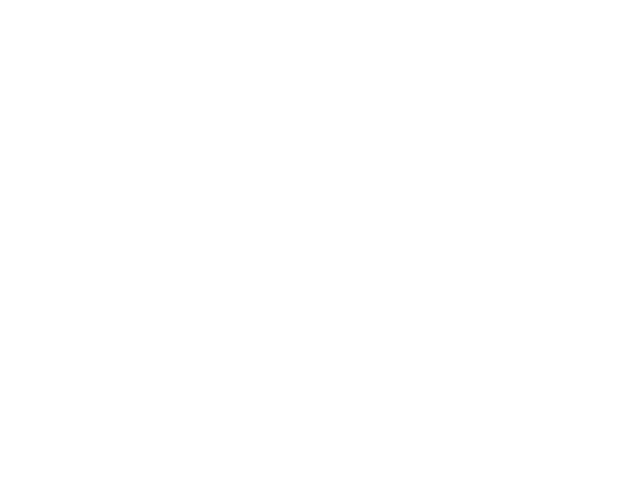

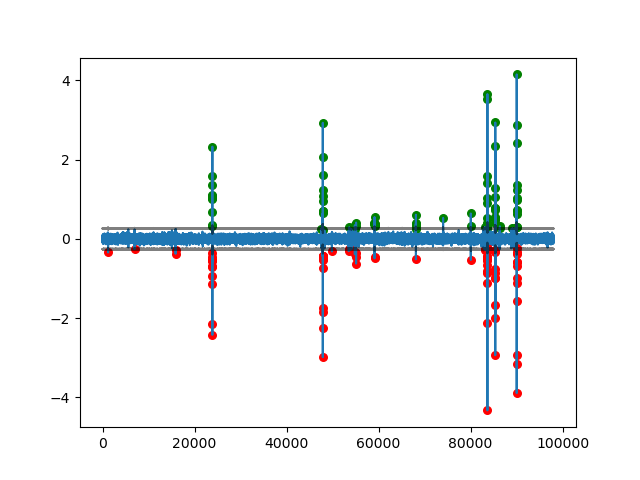

In [25]:
%matplotlib widget

# 4.1
factor = 6
left_threshold, right_threshold = cfar_fast(horizontal_motion, num_guard_cells=1, num_ref_cells=15, bias=noise_level * factor)
l_peak_idxs = []
r_peak_idxs = []
for i, dx in enumerate(horizontal_motion):
    if dx > left_threshold[i]:
        l_peak_idxs.append(i)
    if dx < right_threshold[i]:
        r_peak_idxs.append(i)
        
fig = plt.figure()
fig, ax = plt.subplots(1)
ax.plot(horizontal_motion)
ax.plot(left_threshold, c="black", alpha=0.5)
ax.plot(right_threshold, c="black", alpha=0.5)
# Plot peaks
ax.scatter(l_peak_idxs, horizontal_motion[l_peak_idxs], c='green', s=30)
ax.scatter(r_peak_idxs, horizontal_motion[r_peak_idxs], c='red', s=30)

## Generate dataframe for saving

In [26]:
x_motions = np.zeros(num_frames)

ori_l_idxs = []
ori_r_idxs = []
for i, re in enumerate(res[:-1]):
    x_motions[re] = horizontal_motion[i]
for i in l_peak_idxs:
    ori_l_idxs.append(res[i])
for j in r_peak_idxs:
    ori_r_idxs.append(res[j])

df_right = pd.DataFrame(
    {
        "res": r_peak_idxs,
        "ori": ori_r_idxs
    }
)
df_left = pd.DataFrame(
    {
        "res": l_peak_idxs,
        "ori": ori_l_idxs
    }
)

df_right["xsft"] = x_motions[df_right["ori"].values]
df_left["xsft"] = x_motions[df_left["ori"].values]

df_right["is_left"] = [-1] * len(df_right)
df_left["is_left"] = [1] * len(df_left)
combined_df = pd.concat([df_left, df_right], ignore_index=True)
combined_df.to_csv(f'{save_dir}/x_shift_idx.csv', index=False)

episodes = find_periods(ori_l_idxs, ori_r_idxs, window=60)
np.save(f"{save_dir}/episodes_idx.npy", episodes)

# 

Step 4: Generate clips anad plots for validations

## clips

In [27]:
%%capture
if Path(f'{save_dir}/clips/').exists():
    import shutil
    shutil.rmtree(f'{save_dir}/clips/')

import cv2
video_path = avi
output_folder = f'{save_dir}/clips/'
Path(output_folder).mkdir(parents=True, exist_ok = True)

fps = 200
frame_adjustment = int(fps * 1)  # 1 second worth of frames

# Open the video
cap = cv2.VideoCapture(video_path)

# Get video properties
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Function to add text to a frame
def add_text_to_frame(frame, text):
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_color = (255, 255, 255)  # White color
    font_thickness = 2
    cv2.putText(frame, text, (50, 50), font, font_scale, font_color, font_thickness)
    return frame

# Iterate through the frame ranges
for i, (start_frame, end_frame) in enumerate(episodes):
    # Adjust start and end frames
    adjusted_start = max(0, start_frame - frame_adjustment)
    adjusted_end = min(total_frames - 1, end_frame + frame_adjustment)

    # Set the start frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, adjusted_start)

    # Define the output video writer
    output_path = f'{output_folder}clip_{i+1}_{int(start_frame/fps)}-{int(end_frame/fps)}.mp4'
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps * 0.2, (width, height))

    # Loop through the frames in the range
    for frame_num in range(adjusted_start, adjusted_end + 1):
        ret, frame = cap.read()
        if not ret:
            break

        # Add "episode" text to the frame
        if frame_num in list(range(start_frame, end_frame)):
            frame = add_text_to_frame(frame, "episode")

        # Write the frame to the output video
        out.write(frame)

    # Release the output video writer
    out.release()
    print(f"clips {i+1} is ready")

# Release the video capture object
cap.release()

print("Clips have been successfully created.")

## plots

In [28]:
####################### behaviour plottings

def get_tail_angles(df_tail, heading):
    xy = df_tail.values[:, ::2] + df_tail.values[:, 1::2] * 1j
    midline = -np.exp(1j * np.deg2rad(np.asarray(heading)))
    return -np.angle(np.diff(xy, axis=1) / midline[:, None])

def load_data(h5_path, fs=200):
    df_eye = pd.read_hdf(h5_path, "eye")
    eye_angles = df_eye[[("left_eye", "angle"), ("right_eye", "angle")]].values
    df_tail = pd.read_hdf(h5_path, "tail")
    tail_angles = get_tail_angles(df_tail, df_eye["heading"].values)   

    return eye_angles, tail_angles

def low_pass_filt(x, fs, cutoff, axis=0, order=2):
    from scipy.signal import butter, filtfilt

    b, a = butter(order, cutoff / (fs / 2), btype="low")
    return filtfilt(b, a, x, axis=axis)


In [29]:
fs = 200  # target sampling frequency
eye_angles, tail_angles = load_data(h5_path, fs)
eye_angles_filt = low_pass_filt(eye_angles, fs, 2)
bout_params = {
    "n_angles_avg": 5,  # number of angles to average for tail tip angle
    "sigma": 4,  # sigma for gaussian filter
    "high": 10,  # high threshold for tail vigor
    "low": 5,  # low threshold for tail vigor
}
mean_tip_angle = tail_angles[..., -bout_params["n_angles_avg"] :].mean(-1)

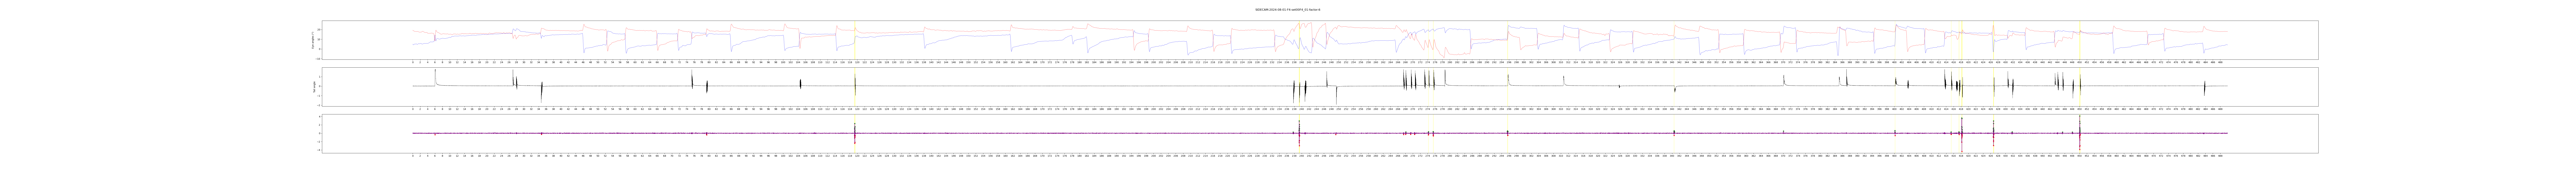

In [30]:
seconds = np.arange(0, int(num_frames / fps),2)
tick_locations = np.arange(0, int(num_frames / fps),2)*200

fig, axes = plt.subplots(3,1, figsize=(150,10)) # 100 8

ax1 = axes[0]
ax1.set_ylabel("Eye angles (°)")
ax1.plot(eye_angles_filt[:, 0], color="b", lw=0.5)
ax1.plot(eye_angles_filt[:, 1], color="r", lw=0.5)
# Set ticks and labels
ax1.set_xticks(tick_locations)
ax1.set_xticklabels([f"{s}" for s in seconds])


ax2 = axes[1]
ax2.set_ylabel("Tail angle")
ax2.plot(mean_tip_angle, color="black", lw=0.5)
# Set ticks and labels
ax2.set_xticks(tick_locations)
ax2.set_xticklabels([f"{s}" for s in seconds])

ax3 = axes[2]
ax3.plot(np.zeros(len(x_motions)))
ax3.stem(np.arange(len(x_motions)), x_motions, linefmt='purple', markerfmt=' ', basefmt=' ')
ax3.scatter(ori_l_idxs, x_motions[ori_l_idxs], c='green', s=15)
ax3.scatter(ori_r_idxs, x_motions[ori_r_idxs], c='red', s=15)
# Set ticks and labels
ax3.set_xticks(tick_locations)
ax3.set_xticklabels([f"{s}" for s in seconds])

for ax in axes:
    for episode in episodes:
        ax.axvspan(episode[0], episode[-1], color='yellow', alpha=0.3, lw=0.5, zorder=-100)
   


title = f"SIDECAM:{fish_id}-set00{set_no}-factor:{factor}"
plt.suptitle(title, y=0.95)

plt.savefig(f"{save_dir}/full_plot.png", transparent=None,
        facecolor='white', dpi = 500
       )

In [31]:
episodes

[[23854, 23857],
 [23858, 23861],
 [23863, 23866],
 [23867, 23870],
 [23871, 23880],
 [47857, 47861],
 [47862, 47865],
 [47866, 47869],
 [47870, 47873],
 [47874, 47876],
 [47877, 47879],
 [54841, 54844],
 [55101, 55103],
 [55108, 55110],
 [59104, 59119],
 [59128, 59132],
 [68096, 68110],
 [80035, 80038],
 [83066, 83074],
 [83481, 83498],
 [83635, 83637],
 [83639, 83642],
 [83643, 83645],
 [83646, 83649],
 [83650, 83651],
 [83653, 83655],
 [83656, 83661],
 [85344, 85347],
 [85348, 85349],
 [85350, 85353],
 [85354, 85355],
 [85357, 85359],
 [85360, 85362],
 [85364, 85365],
 [85367, 85369],
 [90002, 90004],
 [90005, 90008],
 [90009, 90011],
 [90012, 90015],
 [90016, 90018],
 [90020, 90021],
 [90023, 90025],
 [90026, 90031]]

In [ ]:
cycles = []

for i, episode in enumerate(episodes):
    cycle = []
    index = 0
    
    epidsode[]